# 1.21b: Flannel Worldline Comparison

**Goal:** Visualize token trajectories in Flannel 1 (tied weights) vs Flannel 2 (untied weights).

## Visualizations

### 1. Side-by-side comoving spacetime diagrams
- **Left:** Flannel 1 (tied weights)
- **Right:** Flannel 2 (untied weights)
- **Dead tokens:** Red worldlines
- **Live tokens:** Blue worldlines
- **Reference frame:** Dead token centroid (comoving frame, bulk motion removed)

### 2. Differential worldlines
- Plot the *difference* in displacement: d₁(t) - d₂(t) for each token
- Shows which tokens evolve differently between experiments
- Color by live (blue) vs dead (red)

## Comoving Frame

At each timestep t:
1. Compute dead token centroid: $\mathbf{c}_{\text{dead}}(t)$
2. Transform all positions: $\mathbf{W}'_i(t) = \mathbf{W}_i(t) - \mathbf{c}_{\text{dead}}(t)$
3. Compute net displacement: $d_i(t) = \|\mathbf{W}'_i(t) - \mathbf{W}'_i(0)\|$

This removes bulk motion shared by all tokens.

## Parameters

In [1]:
# Data paths
FLANNEL_1_PATH = '../tensors/Flannel/1.20a_flannel_1.safetensors'
FLANNEL_2_PATH = '../tensors/Flannel/1.20b_flannel_2.safetensors'
TOKEN_MASKS_PATH = '../tensors/Flannel/live_dead_tokens.safetensors'

# Visualization
PLOT_DPI = 200
ALPHA_DEAD = 0.03  # Dead token transparency
ALPHA_LIVE = 0.02  # Live token transparency (more tokens, more transparent)
LINEWIDTH = 0.3
FIGSIZE_SPACETIME = (18, 8)  # Wide for side-by-side
FIGSIZE_DIFF = (14, 6)

# Colors
COLOR_DEAD = 'crimson'
COLOR_LIVE = 'steelblue'

## Imports

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from safetensors.torch import load_file

print("✓ Imports complete")

✓ Imports complete


## Device Detection

In [3]:
# Detect available device
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

print(f"Using device: {device}")

Using device: mps


## Load Data

In [4]:
print("Loading data...\n")

# Flannel 1
data_1 = load_file(FLANNEL_1_PATH)
W_1 = data_1['embeddings'].to(torch.float32).to(device)

# Flannel 2
data_2 = load_file(FLANNEL_2_PATH)
W_2 = data_2['embeddings_W'].to(torch.float32).to(device)

# Token masks
masks = load_file(TOKEN_MASKS_PATH)
dead_mask = masks['dead_mask'].to(device)
live_mask = masks['live_mask'].to(device)

n_steps, vocab_size, hidden_dim = W_1.shape
n_dead = dead_mask.sum().item()
n_live = live_mask.sum().item()

print(f"✓ Data loaded")
print(f"  Shape: {W_1.shape}")
print(f"  Vocab: {vocab_size} ({n_live} live, {n_dead} dead)")
print(f"  Steps: {n_steps}")
print(f"  Device: {device}")

Loading data...

✓ Data loaded
  Shape: torch.Size([1001, 10000, 64])
  Vocab: 10000 (6301 live, 3699 dead)
  Steps: 1001
  Device: mps


## Transform to Comoving Frame

Center on dead token centroid at each timestep for both experiments.

In [5]:
print("\nTransforming to comoving frame...\n")

# Compute dead centroids at each timestep
dead_centroid_1 = W_1[:, dead_mask, :].mean(dim=1)  # (n_steps, hidden_dim)
dead_centroid_2 = W_2[:, dead_mask, :].mean(dim=1)

print(f"Flannel 1 dead centroid drift: {torch.norm(dead_centroid_1[-1] - dead_centroid_1[0]).item():.6f}")
print(f"Flannel 2 dead centroid drift: {torch.norm(dead_centroid_2[-1] - dead_centroid_2[0]).item():.6f}")

# Transform to comoving frame
W_1_comoving = W_1 - dead_centroid_1.unsqueeze(1)
W_2_comoving = W_2 - dead_centroid_2.unsqueeze(1)

print(f"\n✓ Transformed to comoving frame")


Transforming to comoving frame...

Flannel 1 dead centroid drift: 0.500009
Flannel 2 dead centroid drift: 0.554825

✓ Transformed to comoving frame


## Compute Net Displacement from Initial Position

For each token at each timestep, compute distance from its initial position in comoving frame.

In [6]:
print("\nComputing net displacements...\n")

def compute_displacement(embeddings_comoving):
    """Compute net displacement from initial position."""
    initial = embeddings_comoving[0]  # (vocab_size, hidden_dim)
    displacement = torch.zeros(n_steps, vocab_size, device=device)
    
    for t in range(n_steps):
        diff = embeddings_comoving[t] - initial
        displacement[t] = torch.norm(diff, p=2, dim=1)
    
    return displacement

# Compute for both experiments
disp_1 = compute_displacement(W_1_comoving)  # (n_steps, vocab_size)
disp_2 = compute_displacement(W_2_comoving)

print(f"✓ Computed displacements")
print(f"  Flannel 1 max final displacement: {disp_1[-1].max().item():.6f}")
print(f"  Flannel 2 max final displacement: {disp_2[-1].max().item():.6f}")


Computing net displacements...

✓ Computed displacements
  Flannel 1 max final displacement: 1.115423
  Flannel 2 max final displacement: 1.227693


## Extract Live and Dead Displacements

In [7]:
# Flannel 1
disp_1_live = disp_1[:, live_mask]  # (n_steps, n_live)
disp_1_dead = disp_1[:, dead_mask]  # (n_steps, n_dead)

# Flannel 2
disp_2_live = disp_2[:, live_mask]
disp_2_dead = disp_2[:, dead_mask]

print(f"\nFlannel 1 final displacements:")
print(f"  Live: mean={disp_1_live[-1].mean().item():.6f}, max={disp_1_live[-1].max().item():.6f}")
print(f"  Dead: mean={disp_1_dead[-1].mean().item():.6f}, max={disp_1_dead[-1].max().item():.6f}")

print(f"\nFlannel 2 final displacements:")
print(f"  Live: mean={disp_2_live[-1].mean().item():.6f}, max={disp_2_live[-1].max().item():.6f}")
print(f"  Dead: mean={disp_2_dead[-1].mean().item():.6f}, max={disp_2_dead[-1].max().item():.6f}")


Flannel 1 final displacements:
  Live: mean=0.386045, max=1.115423
  Dead: mean=0.068949, max=0.115163

Flannel 2 final displacements:
  Live: mean=0.439746, max=1.227693
  Dead: mean=0.079606, max=0.136000


## Plot 1: Side-by-Side Comoving Spacetime Diagrams

**Left:** Flannel 1 (tied weights)  
**Right:** Flannel 2 (untied weights)

Both show dead (red) and live (blue) token worldlines.


Plotting side-by-side spacetime diagrams...

  Plotting Flannel 1...
  Plotting Flannel 2...


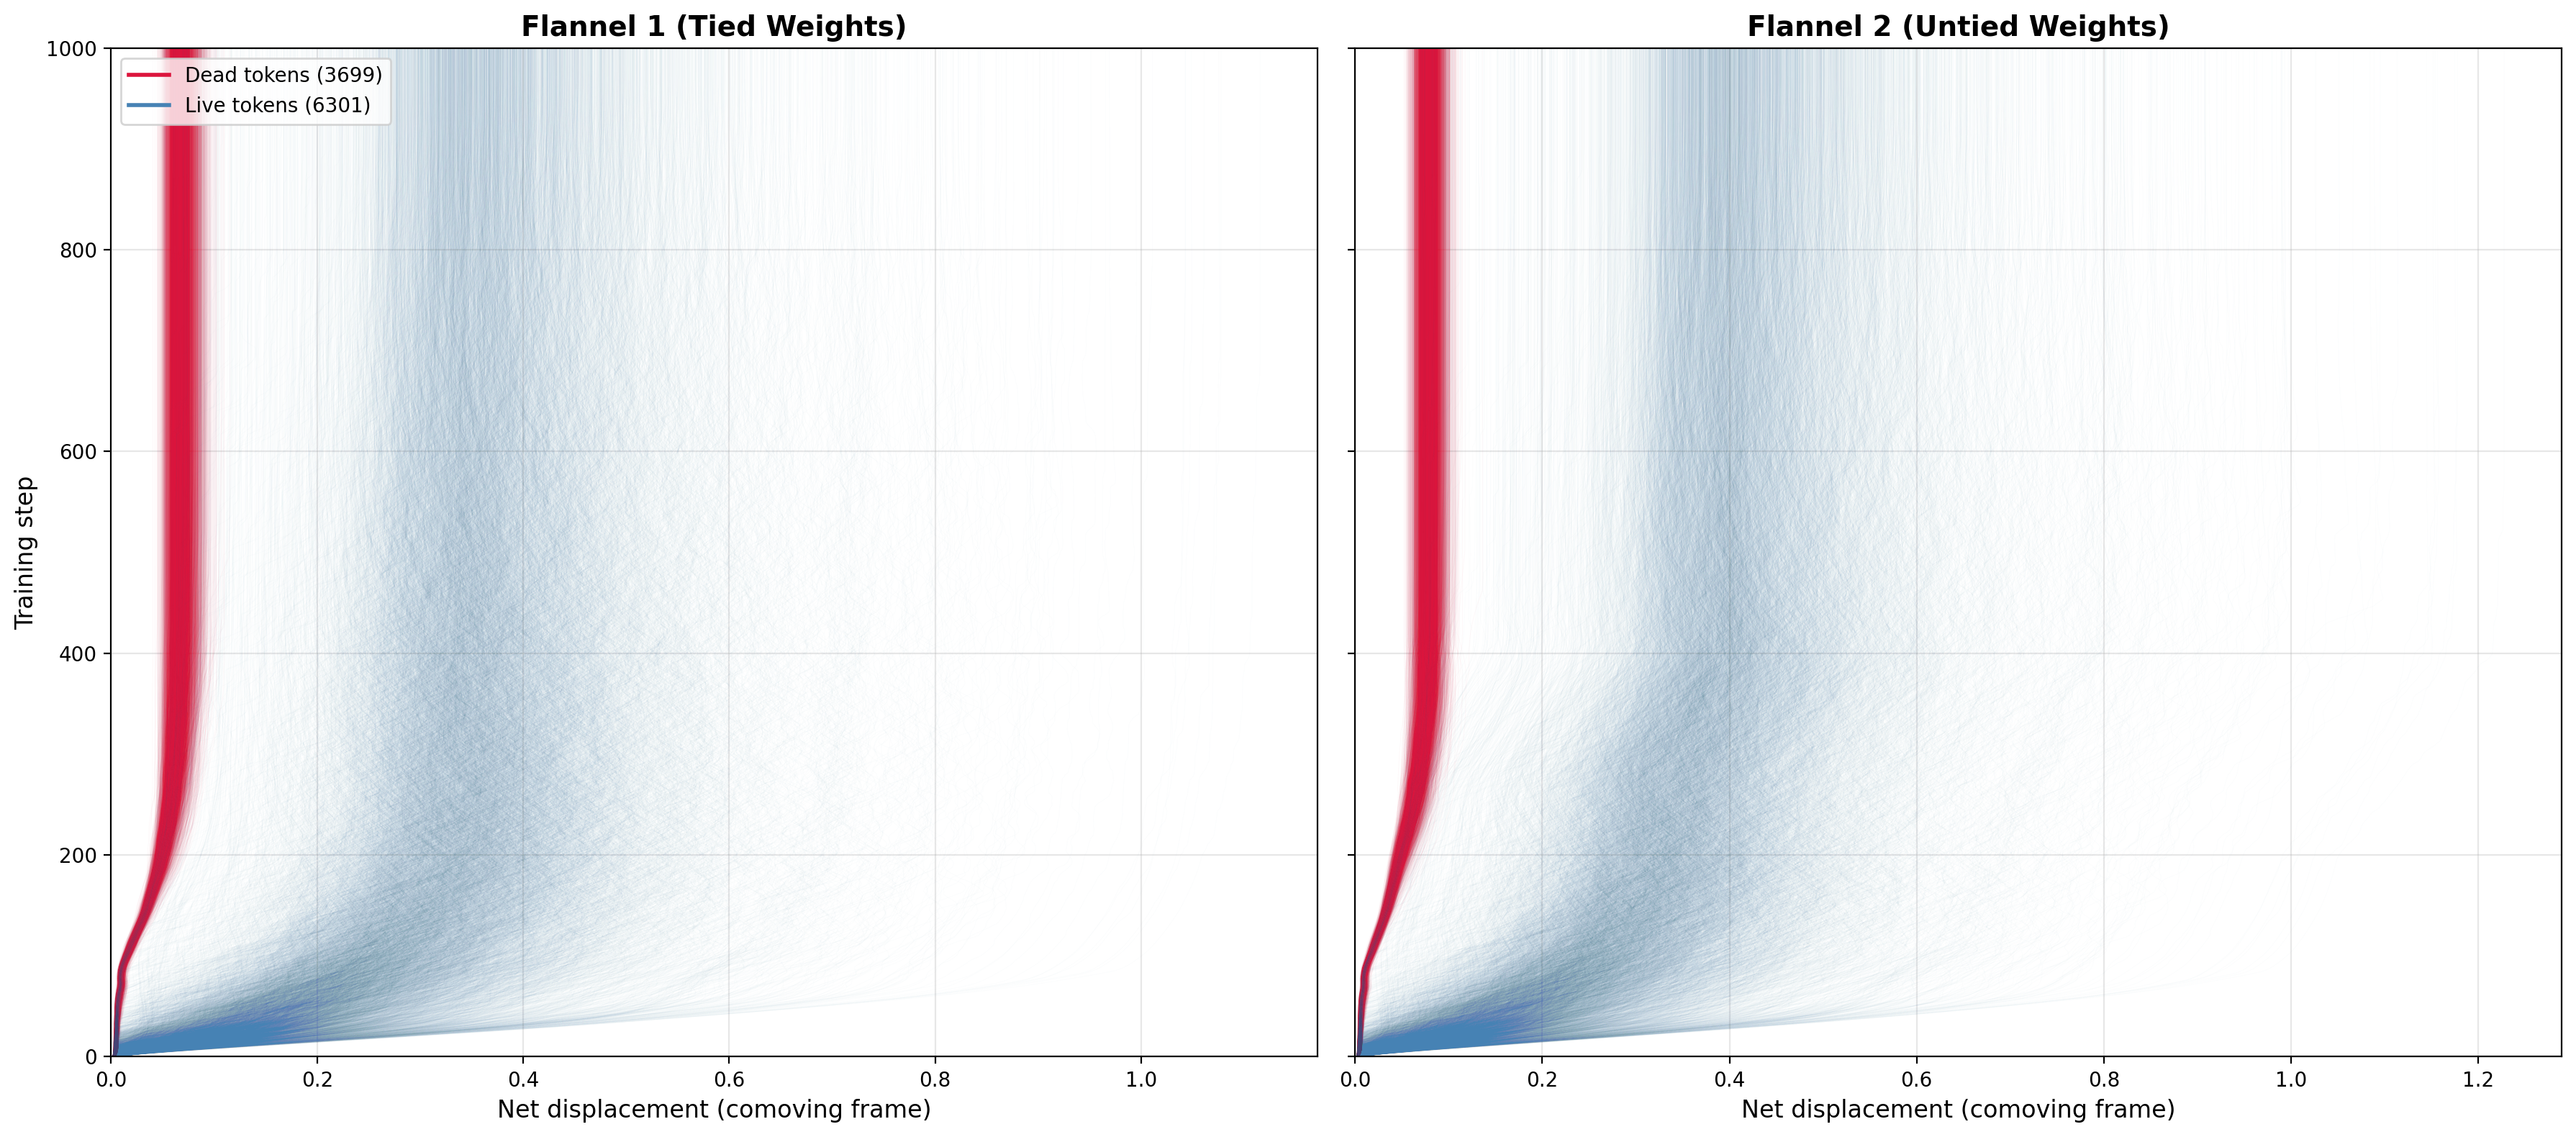


✓ Spacetime diagrams complete


In [8]:
print("\nPlotting side-by-side spacetime diagrams...\n")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=FIGSIZE_SPACETIME, dpi=PLOT_DPI, sharey=True)

timesteps = np.arange(n_steps)

# Convert to CPU for plotting
disp_1_live_cpu = disp_1_live.cpu().numpy()
disp_1_dead_cpu = disp_1_dead.cpu().numpy()
disp_2_live_cpu = disp_2_live.cpu().numpy()
disp_2_dead_cpu = disp_2_dead.cpu().numpy()

# --- Flannel 1 (Left Panel) ---
print("  Plotting Flannel 1...")

# Dead tokens (plot first so live tokens overlay)
for i in range(n_dead):
    ax1.plot(disp_1_dead_cpu[:, i], timesteps, 
             color=COLOR_DEAD, alpha=ALPHA_DEAD, linewidth=LINEWIDTH)

# Live tokens
for i in range(n_live):
    ax1.plot(disp_1_live_cpu[:, i], timesteps, 
             color=COLOR_LIVE, alpha=ALPHA_LIVE, linewidth=LINEWIDTH)

ax1.set_xlabel('Net displacement (comoving frame)', fontsize=12)
ax1.set_ylabel('Training step', fontsize=12)
ax1.set_title('Flannel 1 (Tied Weights)', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.set_xlim(left=0)
ax1.set_ylim(0, n_steps-1)

# Legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color=COLOR_DEAD, linewidth=2, label=f'Dead tokens ({n_dead})'),
    Line2D([0], [0], color=COLOR_LIVE, linewidth=2, label=f'Live tokens ({n_live})')
]
ax1.legend(handles=legend_elements, loc='upper left', fontsize=10)

# --- Flannel 2 (Right Panel) ---
print("  Plotting Flannel 2...")

# Dead tokens
for i in range(n_dead):
    ax2.plot(disp_2_dead_cpu[:, i], timesteps, 
             color=COLOR_DEAD, alpha=ALPHA_DEAD, linewidth=LINEWIDTH)

# Live tokens
for i in range(n_live):
    ax2.plot(disp_2_live_cpu[:, i], timesteps, 
             color=COLOR_LIVE, alpha=ALPHA_LIVE, linewidth=LINEWIDTH)

ax2.set_xlabel('Net displacement (comoving frame)', fontsize=12)
ax2.set_title('Flannel 2 (Untied Weights)', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.set_xlim(left=0)

plt.tight_layout()
plt.show()

print("\n✓ Spacetime diagrams complete")

## Plot 2: Differential Worldlines (d₁ - d₂)

For each token, plot the *difference* in displacement between Flannel 1 and Flannel 2:

$$\Delta d_i(t) = d_{1,i}(t) - d_{2,i}(t)$$

- Positive: token displaced more in Flannel 1 (tied weights)
- Negative: token displaced more in Flannel 2 (untied weights)
- Zero: same displacement in both experiments

In [9]:
print("\nComputing differential displacements...\n")

# Compute difference: d1 - d2
diff_disp = disp_1 - disp_2  # (n_steps, vocab_size)

diff_disp_live = diff_disp[:, live_mask]
diff_disp_dead = diff_disp[:, dead_mask]

print(f"Differential displacement statistics:")
print(f"  Live tokens: mean={diff_disp_live[-1].mean().item():.6f}, std={diff_disp_live[-1].std().item():.6f}")
print(f"  Dead tokens: mean={diff_disp_dead[-1].mean().item():.6f}, std={diff_disp_dead[-1].std().item():.6f}")
print(f"  Overall range: [{diff_disp[-1].min().item():.6f}, {diff_disp[-1].max().item():.6f}]")


Computing differential displacements...

Differential displacement statistics:
  Live tokens: mean=-0.053701, std=0.017292
  Dead tokens: mean=-0.010658, std=0.007359
  Overall range: [-0.251530, 0.021220]



Plotting differential worldlines...



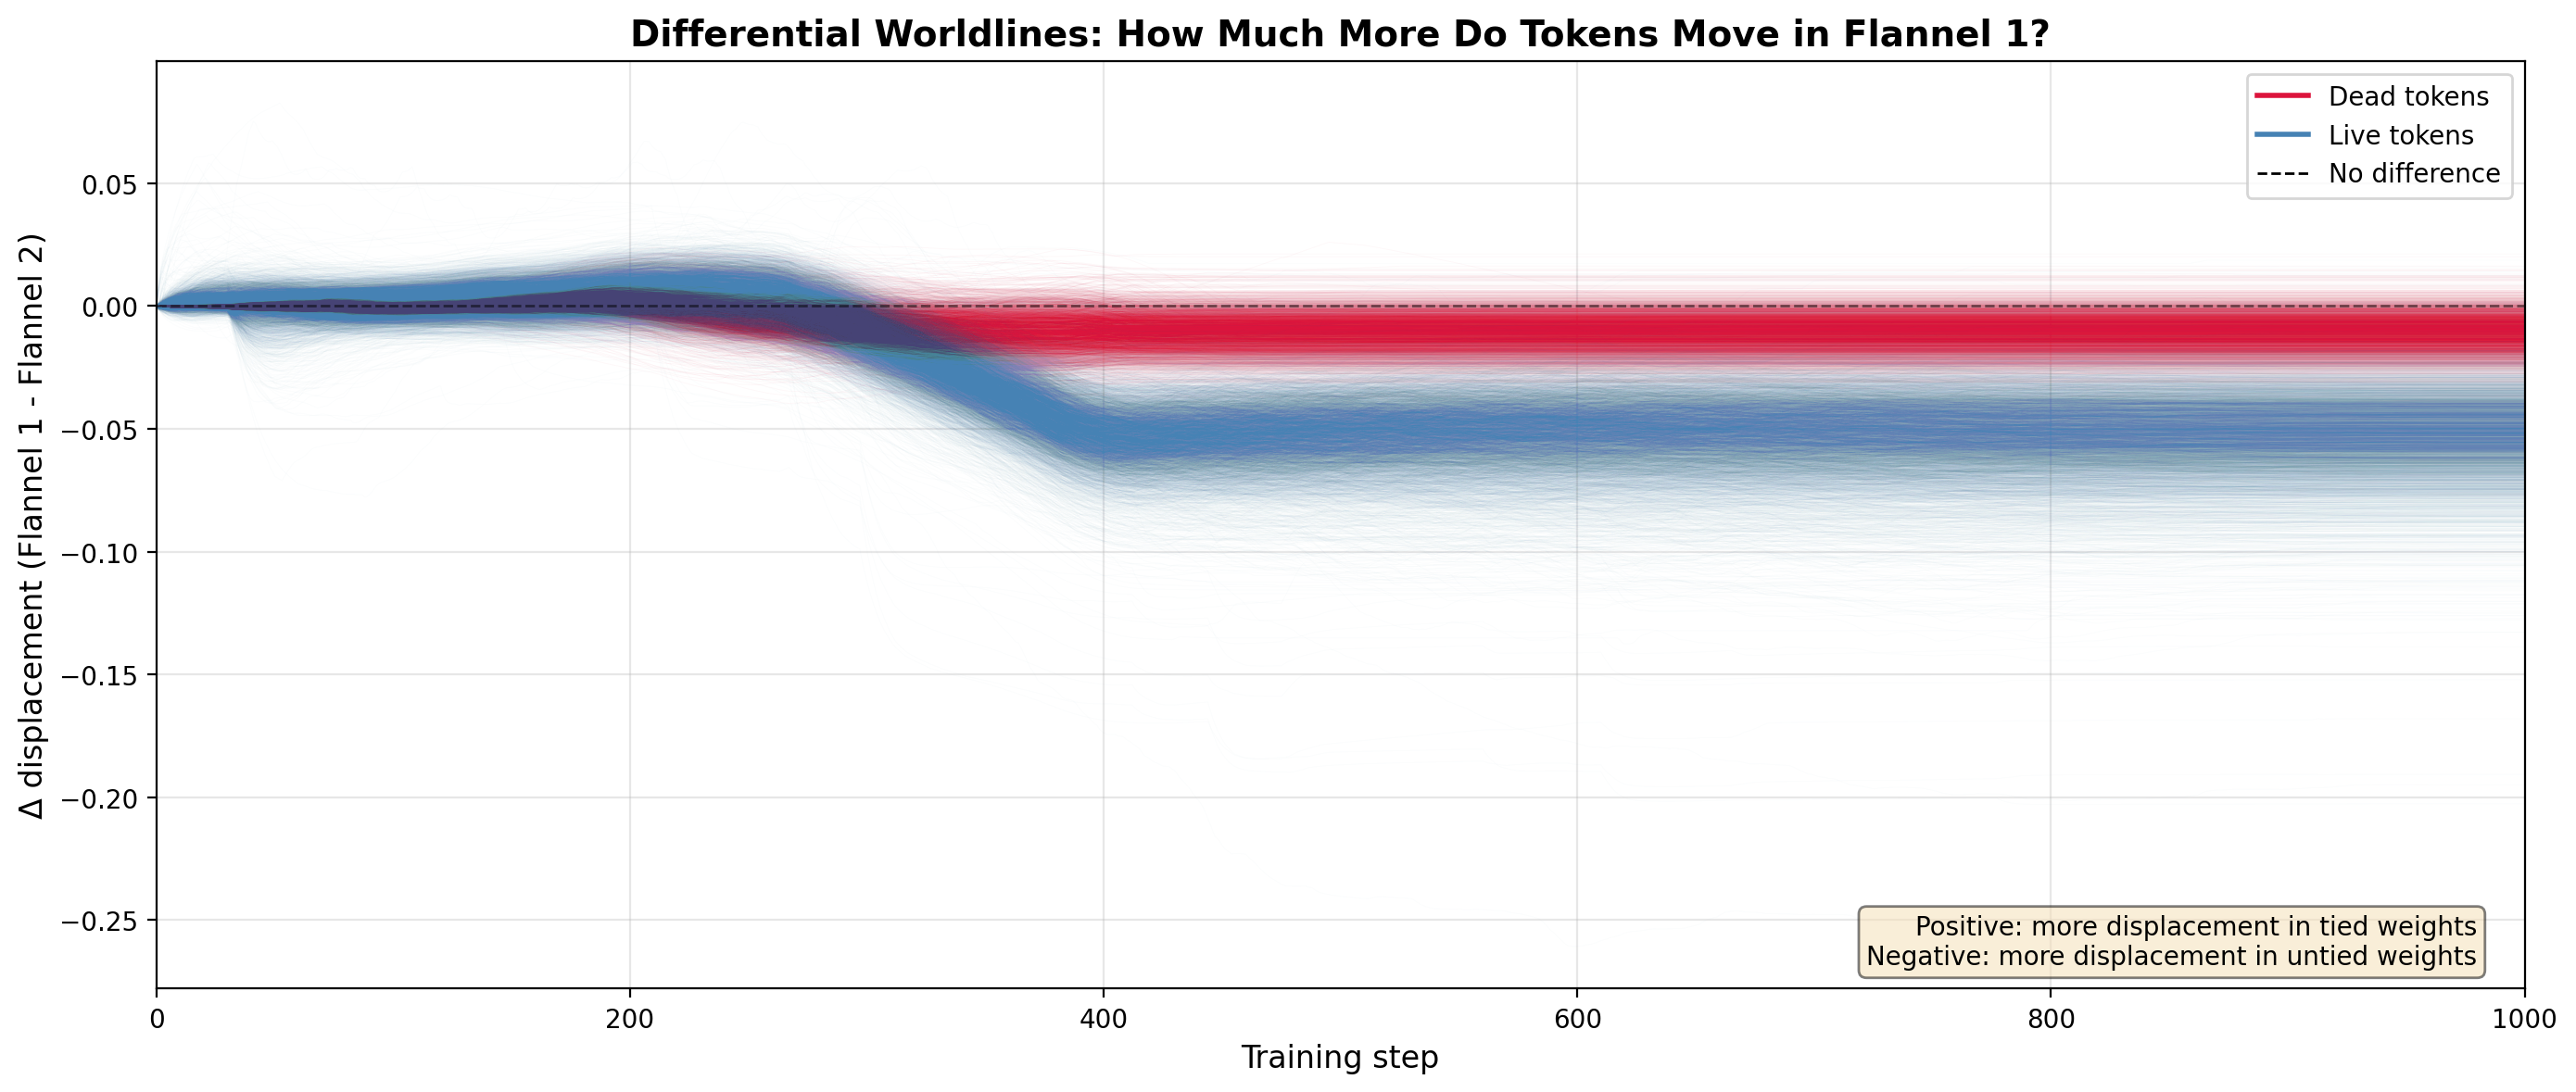


✓ Differential worldlines complete


In [10]:
print("\nPlotting differential worldlines...\n")

fig, ax = plt.subplots(figsize=FIGSIZE_DIFF, dpi=PLOT_DPI)

diff_disp_live_cpu = diff_disp_live.cpu().numpy()
diff_disp_dead_cpu = diff_disp_dead.cpu().numpy()

# Dead tokens
for i in range(n_dead):
    ax.plot(timesteps, diff_disp_dead_cpu[:, i], 
            color=COLOR_DEAD, alpha=ALPHA_DEAD, linewidth=LINEWIDTH)

# Live tokens
for i in range(n_live):
    ax.plot(timesteps, diff_disp_live_cpu[:, i], 
            color=COLOR_LIVE, alpha=ALPHA_LIVE, linewidth=LINEWIDTH)

# Zero line
ax.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5, label='No difference')

ax.set_xlabel('Training step', fontsize=12)
ax.set_ylabel('Δ displacement (Flannel 1 - Flannel 2)', fontsize=12)
ax.set_title('Differential Worldlines: How Much More Do Tokens Move in Flannel 1?', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.set_xlim(0, n_steps-1)

# Legend
legend_elements = [
    Line2D([0], [0], color=COLOR_DEAD, linewidth=2, label=f'Dead tokens'),
    Line2D([0], [0], color=COLOR_LIVE, linewidth=2, label=f'Live tokens'),
    Line2D([0], [0], color='black', linestyle='--', linewidth=1, label='No difference')
]
ax.legend(handles=legend_elements, loc='best', fontsize=10)

# Annotation
ax.text(0.98, 0.02, 
        'Positive: more displacement in tied weights\nNegative: more displacement in untied weights',
        transform=ax.transAxes, fontsize=10, verticalalignment='bottom', 
        horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

print("\n✓ Differential worldlines complete")

## Summary

In [11]:
print("\n" + "="*80)
print("SUMMARY")
print("="*80 + "\n")

print(f"Comparison: Flannel 1 (tied) vs Flannel 2 (untied)")
print(f"  Tokens: {vocab_size} ({n_live} live, {n_dead} dead)")
print(f"  Steps: {n_steps}")
print()

print(f"Final displacements (comoving frame):")
print()
print(f"  Flannel 1 (tied):")
print(f"    Live: {disp_1_live[-1].mean().item():.6f}")
print(f"    Dead: {disp_1_dead[-1].mean().item():.6f}")
print()
print(f"  Flannel 2 (untied):")
print(f"    Live: {disp_2_live[-1].mean().item():.6f}")
print(f"    Dead: {disp_2_dead[-1].mean().item():.6f}")
print()

print(f"Differential displacement (Flannel 1 - Flannel 2):")
print(f"  Live: {diff_disp_live[-1].mean().item():.6f} ± {diff_disp_live[-1].std().item():.6f}")
print(f"  Dead: {diff_disp_dead[-1].mean().item():.6f} ± {diff_disp_dead[-1].std().item():.6f}")
print()

# Interpretation
mean_diff_live = diff_disp_live[-1].mean().item()
mean_diff_dead = diff_disp_dead[-1].mean().item()

print(f"Interpretation:")
if abs(mean_diff_live) < 0.01 and abs(mean_diff_dead) < 0.01:
    print(f"  → Similar trajectories in both experiments")
    print(f"  → Tied vs untied weights make little difference")
else:
    if mean_diff_live > 0:
        print(f"  → Live tokens move MORE in Flannel 1 (tied weights)")
    else:
        print(f"  → Live tokens move MORE in Flannel 2 (untied weights)")
    
    if mean_diff_dead > 0:
        print(f"  → Dead tokens move MORE in Flannel 1 (tied weights)")
    else:
        print(f"  → Dead tokens move MORE in Flannel 2 (untied weights)")

print(f"\n" + "="*80)


SUMMARY

Comparison: Flannel 1 (tied) vs Flannel 2 (untied)
  Tokens: 10000 (6301 live, 3699 dead)
  Steps: 1001

Final displacements (comoving frame):

  Flannel 1 (tied):
    Live: 0.386045
    Dead: 0.068949

  Flannel 2 (untied):
    Live: 0.439746
    Dead: 0.079606

Differential displacement (Flannel 1 - Flannel 2):
  Live: -0.053701 ± 0.017292
  Dead: -0.010658 ± 0.007359

Interpretation:
  → Live tokens move MORE in Flannel 2 (untied weights)
  → Dead tokens move MORE in Flannel 2 (untied weights)

